# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
%cd /mnt/disks/user/project/PROJECT/
#!rm -rf model_init_*

/mnt/disks/user/project/PROJECT


In [2]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import cv2

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size
num_of_images_in_video_frames = 16
image_width = 120
image_height = 120

In [5]:
import matplotlib.pyplot as plt
% matplotlib inline
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

### Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def init_batch_data(batch_size):
    batch_data = np.zeros((batch_size,num_of_images_in_video_frames,image_width,image_height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

In [7]:
def read_batch_image(source_path, img_idx, folder_list, batch, batch_size, ):  
    batch_data,batch_labels = init_batch_data(batch_size)
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ folder_list[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ folder_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            image = imresize(image, (image_width,image_height)).astype(np.float32)
            norm2_image = image - np.min(image)/np.max(image) - np.min(image)
            batch_data[folder,idx,:,:,0] = norm2_image[:, :, 0] #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = norm2_image[:, :, 1] #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = norm2_image[:, :, 2] #normalise and feed in the image
            
        batch_labels[folder, int(folder_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels 

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,15,16,18,20,22,24,26,28]#[x for x in range(0, 30)]  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield read_batch_image(source_path, img_idx, t, batch, batch_size) #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield read_batch_image(source_path, img_idx, t, batch, batch_size)


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout,GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

#write your model here
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(num_of_images_in_video_frames,image_width,image_height,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))

model.add(Dropout(0.25))

model.add(Dense(nb_dense[1], kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2]))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
from keras.optimizers import Adam
from keras.optimizers import SGD
optimiser = Adam(lr=0.00085)
#optimiser = Adam(lr=0.00086) #write your optimizerv .. (1) changed from 80 to 88
#optimiser = SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 16)     64        
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 16)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.20, patience=5, cooldown=1, verbose=1, mode='auto', min_delta=0.0001)
#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, cooldown=1, verbose=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, cooldown=1, verbose=1)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
def build_cnn_model(epoch, batch_sz):
    train_generator = generator(train_path, train_doc, batch_sz)
    val_generator = generator(val_path, val_doc, batch_sz)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_sz)
    else:
        steps_per_epoch = (num_train_sequences//batch_sz) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_sz)
    else:
        validation_steps = (num_val_sequences//batch_sz) + 1
    
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epoch, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
#build_cnn_model(epoch=50, batch_sz=60)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 65
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 65
Epoch 1/300


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


11/11 [==============================] - 50s 5s/step - loss: 8.3257 - categorical_accuracy: 0.2415 - val_loss: 7.5608 - val_categorical_accuracy: 0.3100

Epoch 00001: val_loss improved from inf to 7.56083, saving model to model_init_2019-12-2312_35_41.753400/model-00001-8.37223-0.23680-7.56083-0.31000.h5
Epoch 2/300
11/11 [==============================] - 7s 645ms/step - loss: 7.2335 - categorical_accuracy: 0.2517 - val_loss: 6.8607 - val_categorical_accuracy: 0.2857

Epoch 00002: val_loss improved from 7.56083 to 6.86067, saving model to model_init_2019-12-2312_35_41.753400/model-00002-7.23354-0.25175-6.86067-0.28571.h5
Epoch 3/300
11/11 [==============================] - 9s 843ms/step - loss: 6.6414 - categorical_accuracy: 0.2587 - val_loss: 6.1652 - val_categorical_accuracy: 0.4667

Epoch 00003: val_loss improved from 6.86067 to 6.16517, saving model to model_init_2019-12-2312_35_41.753400/model-00003-6.64137-0.25874-6.16517-0.46667.h5
Epoch 4/300
11/11 [===========================

11/11 [==============================] - 9s 790ms/step - loss: 1.6201 - categorical_accuracy: 0.6434 - val_loss: 1.5194 - val_categorical_accuracy: 0.7000

Epoch 00030: val_loss improved from 1.59712 to 1.51936, saving model to model_init_2019-12-2312_35_41.753400/model-00030-1.62010-0.64336-1.51936-0.70000.h5
Epoch 31/300
11/11 [==============================] - 9s 855ms/step - loss: 1.6111 - categorical_accuracy: 0.6084 - val_loss: 1.3321 - val_categorical_accuracy: 0.7000

Epoch 00031: val_loss improved from 1.51936 to 1.33210, saving model to model_init_2019-12-2312_35_41.753400/model-00031-1.61109-0.60839-1.33210-0.70000.h5
Epoch 32/300
11/11 [==============================] - 9s 788ms/step - loss: 1.5867 - categorical_accuracy: 0.6503 - val_loss: 1.2847 - val_categorical_accuracy: 0.7500

Epoch 00032: val_loss improved from 1.33210 to 1.28470, saving model to model_init_2019-12-2312_35_41.753400/model-00032-1.58666-0.65035-1.28470-0.75000.h5
Epoch 33/300
11/11 [==================

11/11 [==============================] - 9s 844ms/step - loss: 0.9065 - categorical_accuracy: 0.8322 - val_loss: 1.4230 - val_categorical_accuracy: 0.7000

Epoch 00063: val_loss did not improve from 0.84238
Epoch 64/300
11/11 [==============================] - 9s 804ms/step - loss: 0.8615 - categorical_accuracy: 0.8112 - val_loss: 2.0392 - val_categorical_accuracy: 0.4500

Epoch 00064: val_loss did not improve from 0.84238
Epoch 65/300
11/11 [==============================] - 9s 781ms/step - loss: 1.1169 - categorical_accuracy: 0.7413 - val_loss: 5.0643 - val_categorical_accuracy: 0.2500

Epoch 00065: val_loss did not improve from 0.84238
Epoch 66/300
11/11 [==============================] - 9s 850ms/step - loss: 1.0324 - categorical_accuracy: 0.7203 - val_loss: 1.3477 - val_categorical_accuracy: 0.7000

Epoch 00066: val_loss did not improve from 0.84238
Epoch 67/300
11/11 [==============================] - 9s 850ms/step - loss: 0.9885 - categorical_accuracy: 0.8112 - val_loss: 1.2780 

11/11 [==============================] - 9s 819ms/step - loss: 0.4342 - categorical_accuracy: 0.9720 - val_loss: 0.9052 - val_categorical_accuracy: 0.8000

Epoch 00134: val_loss did not improve from 0.55703
Epoch 135/300
11/11 [==============================] - 9s 817ms/step - loss: 0.4127 - categorical_accuracy: 0.9720 - val_loss: 0.7646 - val_categorical_accuracy: 0.8000

Epoch 00135: val_loss did not improve from 0.55703
Epoch 136/300
11/11 [==============================] - 9s 824ms/step - loss: 0.4023 - categorical_accuracy: 0.9720 - val_loss: 0.6915 - val_categorical_accuracy: 0.9000

Epoch 00136: val_loss did not improve from 0.55703
Epoch 137/300
11/11 [==============================] - 9s 826ms/step - loss: 0.4847 - categorical_accuracy: 0.9231 - val_loss: 1.0721 - val_categorical_accuracy: 0.8000

Epoch 00137: val_loss did not improve from 0.55703

Epoch 00137: ReduceLROnPlateau reducing learning rate to 1.3281250176078174e-05.
Epoch 138/300
11/11 [===========================


Epoch 00169: val_loss did not improve from 0.55703
Epoch 170/300
11/11 [==============================] - 9s 794ms/step - loss: 0.4117 - categorical_accuracy: 0.9650 - val_loss: 0.8465 - val_categorical_accuracy: 0.8000

Epoch 00170: val_loss did not improve from 0.55703
Epoch 171/300
11/11 [==============================] - 9s 811ms/step - loss: 0.4023 - categorical_accuracy: 0.9790 - val_loss: 1.2005 - val_categorical_accuracy: 0.7500

Epoch 00171: val_loss did not improve from 0.55703
Epoch 172/300
11/11 [==============================] - 9s 854ms/step - loss: 0.4774 - categorical_accuracy: 0.9371 - val_loss: 0.9336 - val_categorical_accuracy: 0.8500

Epoch 00172: val_loss did not improve from 0.55703
Epoch 173/300
11/11 [==============================] - 9s 861ms/step - loss: 0.4012 - categorical_accuracy: 0.9720 - val_loss: 0.5877 - val_categorical_accuracy: 0.9500

Epoch 00173: val_loss did not improve from 0.55703
Epoch 174/300
11/11 [==============================] - 9s 776ms/

11/11 [==============================] - 9s 788ms/step - loss: 0.3856 - categorical_accuracy: 0.9790 - val_loss: 1.1396 - val_categorical_accuracy: 0.7500

Epoch 00240: val_loss did not improve from 0.43535
Epoch 241/300
11/11 [==============================] - 9s 860ms/step - loss: 0.4752 - categorical_accuracy: 0.9510 - val_loss: 1.0668 - val_categorical_accuracy: 0.8000

Epoch 00241: val_loss did not improve from 0.43535
Epoch 242/300
11/11 [==============================] - 9s 842ms/step - loss: 0.4276 - categorical_accuracy: 0.9790 - val_loss: 0.6605 - val_categorical_accuracy: 0.8000

Epoch 00242: val_loss did not improve from 0.43535
Epoch 243/300
11/11 [==============================] - 9s 821ms/step - loss: 0.4041 - categorical_accuracy: 0.9650 - val_loss: 1.1409 - val_categorical_accuracy: 0.8000

Epoch 00243: val_loss did not improve from 0.43535
Epoch 244/300
11/11 [==============================] - 9s 839ms/step - loss: 0.4705 - categorical_accuracy: 0.9231 - val_loss: 0.7

11/11 [==============================] - 9s 849ms/step - loss: 0.3917 - categorical_accuracy: 0.9650 - val_loss: 1.1692 - val_categorical_accuracy: 0.7000

Epoch 00276: val_loss did not improve from 0.43535
Epoch 277/300
11/11 [==============================] - 9s 852ms/step - loss: 0.4312 - categorical_accuracy: 0.9510 - val_loss: 1.0349 - val_categorical_accuracy: 0.8000

Epoch 00277: val_loss did not improve from 0.43535
Epoch 278/300
11/11 [==============================] - 9s 824ms/step - loss: 0.4606 - categorical_accuracy: 0.9371 - val_loss: 0.6239 - val_categorical_accuracy: 0.8500

Epoch 00278: val_loss did not improve from 0.43535

Epoch 00278: ReduceLROnPlateau reducing learning rate to 3.2424927187690855e-09.
Epoch 279/300
11/11 [==============================] - 8s 745ms/step - loss: 0.3961 - categorical_accuracy: 0.9580 - val_loss: 1.0132 - val_categorical_accuracy: 0.8000

Epoch 00279: val_loss did not improve from 0.43535
Epoch 280/300
11/11 [===========================

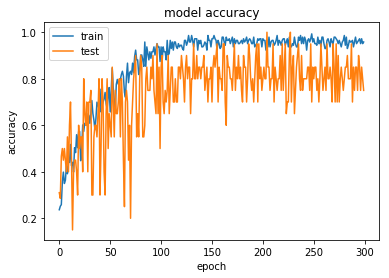

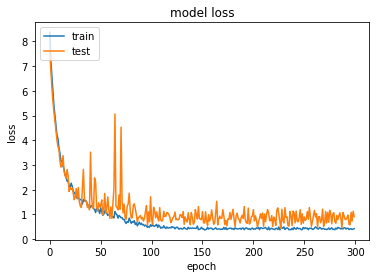

In [15]:
build_cnn_model(epoch=300, batch_sz=65)

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
rnn_batch_sz = 25
rnn_num_epochs = 70
rnn_num_of_images_in_video_frames = 15
def rnn_init_batch_data(batch_size):
    batch_data = np.zeros((batch_size,rnn_num_of_images_in_video_frames,image_width,image_height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels
def rnn_read_batch_image(source_path, img_idx, folder_list, batch, batch_size, ):  
    batch_data,batch_labels = rnn_init_batch_data(batch_size)
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ folder_list[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ folder_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            image = imresize(image, (image_width,image_height)).astype(np.float32)
            norm2_image = image - np.min(image)/np.max(image) - np.min(image)
            batch_data[folder,idx,:,:,0] = norm2_image[:, :, 0] #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = norm2_image[:, :, 1] #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = norm2_image[:, :, 2] #normalise and feed in the image
            
        batch_labels[folder, int(folder_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels 
def rnn_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield rnn_read_batch_image(source_path, img_idx, t, batch, batch_size) #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield rnn_read_batch_image(source_path, img_idx, t, batch, batch_size)

input_shape=(rnn_num_of_images_in_video_frames,image_width,image_height,3)
train_generator = rnn_generator(train_path, train_doc, rnn_batch_sz)
val_generator = rnn_generator(val_path, val_doc, rnn_batch_sz)
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/rnn_batch_sz)
else:
    steps_per_epoch = (num_train_sequences//rnn_batch_sz) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/rnn_batch_sz)
else:
    validation_steps = (num_val_sequences//rnn_batch_sz) + 1    
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(image_width,image_height,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(128, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_rnn = Sequential()
model_rnn.add(TimeDistributed(conv_model, input_shape=input_shape))
model_rnn.add(GRU(64, return_sequences=True))
model_rnn.add(GRU(32))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(8, activation='relu'))
model_rnn.add(Dense(5, activation='softmax'))



#optimiser = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.7, nesterov=True)
optimiser = Adam(lr=0.00085) #write your optimizer
model_rnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_rnn.summary())



history = model_rnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=rnn_num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 128)           15304640  
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 64)            37056     
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 45        
Total params: 15,351,317
Trainable params: 636,629
Non-trainable params: 14,714,688
__________________________________________________________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


27/27 [==============================] - 56s 2s/step - loss: 1.6555 - categorical_accuracy: 0.2112 - val_loss: 1.5856 - val_categorical_accuracy: 0.3040

Epoch 00001: saving model to model_init_conv_lstm_2019-12-2312_35_41.753400/model-00001-1.65908-0.20814-1.58561-0.30400.h5
Epoch 2/70
27/27 [==============================] - 22s 805ms/step - loss: 1.6084 - categorical_accuracy: 0.2194 - val_loss: 1.6045 - val_categorical_accuracy: 0.3680

Epoch 00002: saving model to model_init_conv_lstm_2019-12-2312_35_41.753400/model-00002-1.60838-0.21937-1.60450-0.36800.h5
Epoch 3/70
27/27 [==============================] - 23s 842ms/step - loss: 1.5787 - categorical_accuracy: 0.2450 - val_loss: 1.5367 - val_categorical_accuracy: 0.4240

Epoch 00003: saving model to model_init_conv_lstm_2019-12-2312_35_41.753400/model-00003-1.57871-0.24501-1.53670-0.42400.h5
Epoch 4/70
27/27 [==============================] - 24s 888ms/step - loss: 1.5427 - categorical_accuracy: 0.2877 - val_loss: 1.5513 - val_cat


Epoch 00056: saving model to model_init_conv_lstm_2019-12-2312_35_41.753400/model-00056-0.05862-0.98860-0.70029-0.80000.h5
Epoch 57/70
27/27 [==============================] - 24s 881ms/step - loss: 0.0589 - categorical_accuracy: 0.9915 - val_loss: 0.6976 - val_categorical_accuracy: 0.8240

Epoch 00057: saving model to model_init_conv_lstm_2019-12-2312_35_41.753400/model-00057-0.05892-0.99145-0.69759-0.82400.h5
Epoch 58/70
27/27 [==============================] - 25s 935ms/step - loss: 0.0596 - categorical_accuracy: 0.9915 - val_loss: 0.6885 - val_categorical_accuracy: 0.8160

Epoch 00058: saving model to model_init_conv_lstm_2019-12-2312_35_41.753400/model-00058-0.05964-0.99145-0.68850-0.81600.h5
Epoch 59/70
27/27 [==============================] - 25s 921ms/step - loss: 0.0525 - categorical_accuracy: 0.9943 - val_loss: 0.6264 - val_categorical_accuracy: 0.8400

Epoch 00059: saving model to model_init_conv_lstm_2019-12-2312_35_41.753400/model-00059-0.05252-0.99430-0.62645-0.84000.h5


dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


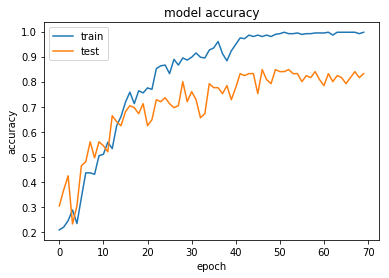

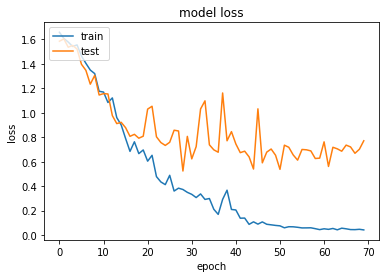

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()